# Homework 5 - Taming text

## Introduction

In this homework, a large corpus of emails released in public during the Hillary Clinton email controversy will be explored. The corpus is stored in `Data` directory. More informtion of the schema is available [here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

In [2]:
from os import path
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import string
import re
import pycountry
from functools import partial
from cleaning import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

## 1. Word clouds
Generate two word clouds:
* One based on the raw corpus
* One based on the corpus pre-processed using the standard text pipeline. 

### a. __Raw text__

The data we are going to use for producing the clouds is taken from the file `Emails.csv` and refers to the column `MetadataSubject, ExtractedSubject, Extractedbody`. Hence, before proceeding to build up a unique cloud, we sould concatenate all the body and subject of the emails. In particular, we do the following:
* Import the data related to the Emails.

In [7]:
# Read data
emails = pd.read_csv('Data/Emails.csv', sep = ',')
emails.sample(3)

Id  DocNumber                              MetadataSubject MetadataTo  \
1869  1870  C05762332  I JUST DROPPED BFG BOOK OFF AT YOUR HOUSE.           H   
4003  4004  C05767230       FEEDBACK ON MIDDLE EAST COMMENTS TODAY          H   
5004  5005  C05769389                                   NAPOLITANO          H   

           MetadataFrom  SenderPersonId           MetadataDateSent  \
1869       Abedin, Huma            81.0  2009-06-14T04:00:00+00:00   
4003  Crowley, Philip J           168.0  2010-02-03T05:00:00+00:00   
5004       Abedin, Huma            81.0  2010-01-24T05:00:00+00:00   

           MetadataDateReleased  \
1869  2015-06-30T04:00:00+00:00   
4003  2015-08-31T04:00:00+00:00   
5004  2015-08-31T04:00:00+00:00   

                                        MetadataPdfLink MetadataCaseNumber  \
1869  DOCUMENTS/HRCAll_1_1-29_JuneWEB/AddBacks/DOC_0...       F-2014-20439   
4003  DOCUMENTS/HRCEmail_August_Web/IPS-0062/DOC_0C0...       F-2014-20439   
5004  DOCUMENTS/HRCEmail_August_Web/IPS-0060/DOC_0C0...       F-2014-20439   

                            ...                          \
1869                        ...                           
4003                        ...                           
5004                        ...                           

                  ExtractedTo                            ExtractedFrom  \
1869                      NaN         Abedin, Huma <AbedinH@state.gov>   
4003                        H  Crowley, Philip J <CrowleyPJ@state.gov>   
5004  H; 'ValmoroU@state.gov'                            Huma Abedin <   

                                            ExtractedCc  \
1869                                                NaN   
4003  Feltman, Jeffrey D; Abedin, Huma; Sullivan, Ja...   
5004                                                NaN   

                         ExtractedDateSent ExtractedCaseNumber  \
1869         Sunday, June 14, 2009 9:44 PM        F-2014-20439   
4003  Wednesday, February 3, 2010 10:50 PM        F-2014-20439   
5004     Sunday, January 24, 2010 10:27 AM        F-2014-20439   

     ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
1869          C05762332            06/30/2015              RELEASE IN PART   
4003          C05767230            08/31/2015              RELEASE IN PART   
5004          C05769389            08/31/2015              RELEASE IN PART   

                                      ExtractedBodyText  \
1869  B6\nMy random stuff can wait till the morning:...   
4003  Madam Secretary, good evening. I just received...   
5004               Yes ops is reaching out to her soon.   

                                                RawText  
1869  UNCLASSIFIED U.S. Department of State Case No....  
4003  UNCLASSIFIED U.S. Department of State Case No....  
5004  UNCLASSIFIED U.S. Department of State Case No....  

[3 rows x 22 columns]

Due to the presence of missing data for the variable related to the `Subject`:
* Get the indeces of the email without `MetadataSubject`

In [4]:
index_null = emails[emails['MetadataSubject'].isnull()].index

* Get the indeces of the email without `ExtractedSubject`

In [5]:
index_null_extracted = emails[emails['ExtractedSubject'].isnull()].index

Then, compute the intersection to see which are the emails that merging the information contained in the two columns will remain unknown.

In [6]:
# Number that should remain null
print ("Number of email we do not know the subject: ", len(set(index_null).intersection(set(index_null_extracted))))

Number of email we do not know the subject:  250


We prefer using the `MetadataSubject` since it appears more cleaned, we use the information in `ExtractedSubject` though. Here we replace the null values of the former with those of the latter, whether it has it.

In [9]:
# For each mail without the subject
for i in index_null:
    emails.loc[i,'MetadataSubject'] = emails.loc[i, 'ExtractedSubject']

The entries that remain nulls even after these operation are filled in with the expression `No title`. The same is done for the bodies of the emails substituting the empty fields with the expression `No body text`.

In [10]:
# Get the subject - replacing nans
emails['MetadataSubject'].fillna('No title', inplace = True)

In [11]:
# Get bodies - replace nans
emails['ExtractedBodyText'].fillna('No body text', inplace = True)

* Extract the column relates to the corpus.

In [12]:
# Useful data
email_corpus = emails[['MetadataSubject', 'ExtractedBodyText']]

* Create a *unique* corpus.

We choose the columns of the data that provide some useful information - merged columns for subject of the email and also body text.

In [13]:
# Create a unique string from the list of entries for the subject feature
unique_corpus_1 = ' '.join([email_corpus['MetadataSubject'][i] for i in range(len(email_corpus))])

# Create a unique string from the list of entries for the body feature
unique_corpus_2 = ' '.join([email_corpus['ExtractedBodyText'][i] for i in range(len(email_corpus))])

In [14]:
# Get the raw corpus
unique_corpus = ' '.join([unique_corpus_1] + [unique_corpus_2])

At first we remove all the characters that contain punctuation.

In [15]:
for c in string.punctuation:
    unique_corpus = unique_corpus.replace(c," ")

Thus, we generate the word cloud. For the moment, in order to indentify the most frequent words, we decide not to fix the maximum font size.

In [16]:
# Generate the word cloud 
wordcloud = WordCloud().generate(unique_corpus)

Visualize the output cloud!

(-0.5, 399.5, 199.5, -0.5)

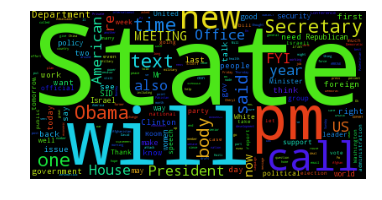

In [17]:
# Display the generated cloud
plt.imshow(wordcloud)
plt.axis("off")

### b. Pre-processed text

To preprocess the text we proceed with these steps ([`clean_entire_corpus`](cleaning.py)):

* Tokenize the corpus and we receive the list of words to further procedure.
* Remove meaningless, short tokens and we put the rest of them into lowercase.
* Get rid of a list of stowords extended by the common words we found in the cloud above (to extend the list of meaningless words we go through the list of the firs words cloud)
* We considered using stemming techniques but we abandoned this idea while it couldn't give us more descriptive view of the email content. Also we find not stemmed words easier to proceed.

In [39]:
# Get the list to extend the stopwords list
extra = [line.rstrip('\n').strip() for line in open('extra_stopwords.txt')]

Thus, we preprocess the code.

In [46]:
# Obtain the corpus
corpus = clean_entire_corpus(unique_corpus, 3, extra)

And we proceed generating the cloud of words.

(-0.5, 399.5, 199.5, -0.5)

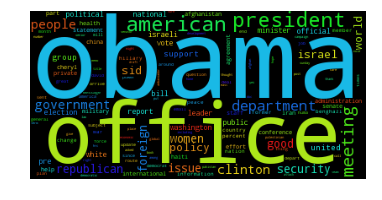

In [47]:
plt.imshow(WordCloud().generate(corpus))
plt.axis("off")

Comparing the two clouds we clearly see how different they are in terms of *"key words"*. The raw corpus contains a lot of meaningless words that occur often in the emails (just because element of the grammar or standard part of a body email), it leads to the lack of information in the cloud. Beside, the second cloud, thanks to the cleaning, seems to be more capable of describing the email contents.

## 2.
Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

In [24]:
def clean_body(x):
    
    # IMPORTANT STOPWORD IS A VARIABLE ALREADY DECLEARED OUTSIDE
    
    # Tokenize
    text = nltk.word_tokenize(x)
    
    # Replace the comma adding space and go to lowercase
    replace_comma = [(i.replace(',', ', ')).lower() for i in text]
    #print (replace_comma)
    # Get rid of this list of two letters words
    get_rid = list(stop_words) + ["re", "fm", "tv", "al", "aq", "la", "ben", "no", "pm", 'cc', 'com', 'mr', 'us', 'fw']
    list_words = [i for i in replace_comma if i not in get_rid and len(i) > 1]
       
    # Get back to the string
    join_list = " ".join(list_words)
    
    # Remove all the punctuation
    for c in string.punctuation:
        join_list = join_list.replace(c," ")
    
    text_new = nltk.word_tokenize(join_list)
    get_rid = list(stop_words) + ["re", "fm", "tv", "al", "aq", "la", "ben", "no", "pm", 'cc', 'com', 'mr', 'us', 'fw']
    list_words = [i for i in text_new if i not in get_rid and len(i) > 1]
    
    return list_words

In [26]:
emails['ExtractedBodyText_2'] = emails['ExtractedBodyText'].apply(clean_body)

In [28]:
list(pycountry.countries)

[Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533'),
 Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan'),
 Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola'),
 Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660'),
 Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248'),
 Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania'),
 Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra'),
 Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784'),
 Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic'),
 Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia'),
 Country(alpha_2='AS', alpha_3='ASM', nam

In [29]:
list_country = list(pycountry.countries)
country_dictionary = {}
country_set = []
for country in list_country:
    country_dictionary[(country.name).lower()] = [(country.alpha_2).lower(), (country.alpha_3).lower()]
    
    if (country.name).lower() == 'syrian arab republic':
        country_dictionary[(country.name).lower()] += ['syria']
    elif (country.name).lower() == 'russian federation':
        country_dictionary[(country.name).lower()] += ['russia']
    elif (country.name).lower() == 'united kingdomn':
        country_dictionary[(country.name).lower()] += ['uk', 'great britain']
    
    country_set.append((country.alpha_2).lower())
    country_set.append((country.alpha_3).lower())
    country_set.append((country.name).lower())
    
country_set += ['syria', 'russia', 'uk', 'great britain']
country_set = set(country_set)

In [84]:
from collections import defaultdict
mentions_dictionary = defaultdict(int)

In [85]:
keys = list(country_dictionary.keys())

for mail in emails['ExtractedBodyText_2']:
    for i in set(mail):
        if i in country_set:  
            
            # Insert the sentiment analysis add values to dictionary
            
            print (i)
            for k in keys:

                if k == i:
                    print ('if',k)
                    mentions_dictionary[k] += 1


                else:

                    values = country_dictionary[k]

                    for v in values:
                        if v == i:
                            print ('else', k)
                            mentions_dictionary[k] += 1                      

libya
if libya
syria
else syrian arab republic
libya
if libya
syria
else syrian arab republic
libya
if libya
syria
else syrian arab republic
libya
if libya
libya
if libya
arm
else armenia
col
else colombia
iraq
if iraq
russia
else russian federation
mn
else mongolia
libya
if libya
china
if china
france
if france
afghanistan
if afghanistan
libya
if libya
malta
if malta
libya
if libya
libya
if libya
libya
if libya
yemen
if yemen
egypt
if egypt
libya
if libya
yemen
if yemen
syria
else syrian arab republic
chad
if chad
qa
else qatar
egypt
if egypt
mm
else myanmar
libya
if libya
israel
if israel
na
else namibia
france
if france
gi
else gibraltar
egypt
if egypt
libya
if libya
tun
else tunisia
ws
else samoa
libya
if libya
cy
else cyprus
lie
else liechtenstein
ai
else anguilla
libya
if libya
aia
else anguilla
egypt
if egypt
libya
if libya
iraq
if iraq
egypt
if egypt
libya
if libya
syria
else syrian arab republic
israel
if israel
egypt
if egypt
libya
if libya
fin
else finland
ago
else angola
pg

In [86]:
mentions_dictionary

defaultdict(int,
            {'afghanistan': 130,
             'albania': 2,
             'algeria': 3,
             'andorra': 22,
             'angola': 127,
             'anguilla': 9,
             'antarctica': 2,
             'antigua and barbuda': 2,
             'argentina': 15,
             'armenia': 19,
             'australia': 25,
             'austria': 5,
             'azerbaijan': 11,
             'bahamas': 2,
             'bahrain': 3,
             'bangladesh': 6,
             'barbados': 11,
             'belarus': 1,
             'belgium': 6,
             'bermuda': 5,
             'bhutan': 2,
             'bolivia, plurinational state of': 1,
             'bosnia and herzegovina': 2,
             'brazil': 31,
             'british indian ocean territory': 2,
             'brunei darussalam': 6,
             'burundi': 10,
             'cabo verde': 5,
             'cambodia': 2,
             'cameroon': 5,
             'canada': 157,
             'cayman islands

In [91]:
# Keep countries with mentions greater than 50
dict_big_mentions = {}
for c in list(mentions_dictionary.keys()):
    if mentions_dictionary[c] > 30:
        dict_big_mentions[c] = mentions_dictionary[c]

In [92]:
dict_big_mentions

{'afghanistan': 130,
 'angola': 127,
 'brazil': 31,
 'canada': 157,
 'china': 95,
 'colombia': 95,
 'egypt': 36,
 'france': 32,
 'germany': 57,
 'haiti': 84,
 'india': 59,
 'indonesia': 37,
 'iraq': 71,
 'ireland': 39,
 'israel': 97,
 'jamaica': 37,
 'libya': 60,
 'mexico': 39,
 'montserrat': 55,
 'pakistan': 96,
 'panama': 36,
 'peru': 72,
 'russian federation': 55,
 'sao tome and principe': 37,
 'senegal': 38,
 'turkey': 36}

In [35]:
import operator

In [36]:
sorted_dict = sorted(dict_big_mentions.items(), key=operator.itemgetter(1))

In [37]:
sorted_dict

[('morocco', 64),
 ('palau', 64),
 ('colombia', 74),
 ('india', 81),
 ('canada', 81),
 ('ireland', 82),
 ('peru', 85),
 ('iraq', 89),
 ('angola', 93),
 ('israel', 104),
 ('pakistan', 132),
 ('libya', 172),
 ('haiti', 173),
 ('afghanistan', 177),
 ('china', 281)]

In [38]:
import seaborn as sns

In [39]:
sorted_dict[0]

('morocco', 64)

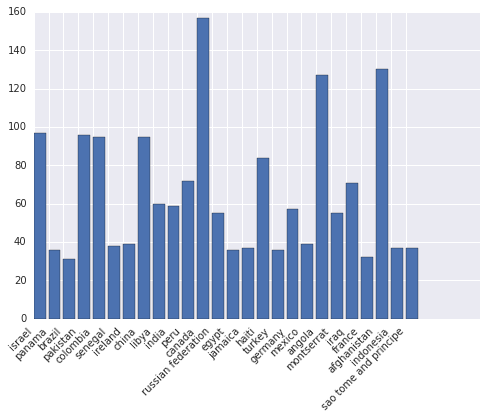

In [93]:


plt.bar(range(len(dict_big_mentions)), list(dict_big_mentions.values()))
plt.xticks(range(len(dict_big_mentions)), list(dict_big_mentions.keys()))
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
for text in emails['ExtractedBodyText']:
    analyzer = SentimentIntensityAnalyzer()
    c = analyzer.polarity_scores(text)
    print (c)

{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.3612, 'pos': 1.0, 'neg': 0.0}
{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.821, 'compound': -0.8402, 'pos': 0.039, 'neg': 0.14}
{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.2023, 'pos': 1.0, 'neg': 0.0}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.357, 'compound': 0.2023, 'pos': 0.643, 'neg': 0.0}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.2023, 'pos': 1.0, 'neg': 0.0}
{'neu': 0.8, 'compound': 0.9881, 'pos': 0.111, 'neg': 0.089}
{'neu': 0.786, 'compound': 0.9259, 'pos': 0.188, 'neg': 0.026}
{'neu': 0.795, 'compound': 0.8869, 'pos': 0.137, 'neg': 0.069}
{'neu': 0.633, 'compound': 0.4404, 'pos': 0.367, 'neg': 0.0}
{'ne

In [81]:
a

"Pls print.\nH <hrod17@clintonemail.com >\nSunday, October 11, 2009 5:03 PM\n'JilotyLC@state.gov'\nFw: Thanks so much for the talk"

In [82]:
analyzer = SentimentIntensityAnalyzer()

In [83]:
analyzer.polarity_scores(a)

{'compound': 0.4939, 'neg': 0.0, 'neu': 0.781, 'pos': 0.219}

## 3.

## 4. *BONUS*